# **ML-7. Прогнозирование биологического ответа**

## Описание задачи

Наша практика будет основана на соревновании [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа).
Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## Знакомство с данными


Данные представлены в формате CSV.  Каждая строка представляет молекулу.

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.



In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

C:\Users\Юзер\AppData\Local\Temp\ipykernel_2876\3685970446.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
data = pd.read_csv('data/train_sem09.zip')
data.head(10)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.00,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.00,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.00,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.50,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.00,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
5,0,0.133333,0.771035,0.20,0.25,0.122153,0.677398,0.267224,0.611112,0.701421,...,0,0,0,0,0,0,0,0,0,0
6,1,0.066700,0.567401,0.10,0.00,0.116578,0.689802,0.274886,0.548509,0.785429,...,0,0,0,0,0,0,0,0,0,0
7,1,0.133333,0.610057,0.15,0.00,0.105176,0.759602,0.313393,0.491790,0.756010,...,0,0,1,0,1,0,0,0,0,0
8,1,0.000000,0.776816,0.05,0.00,0.458446,0.738631,0.246347,0.067800,0.751861,...,0,0,0,0,0,0,0,0,0,0
9,0,0.100000,0.768150,0.10,0.25,0.262299,0.598972,0.377065,0.394514,0.673797,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


1    0.542255
0    0.457745
Name: Activity, dtype: float64

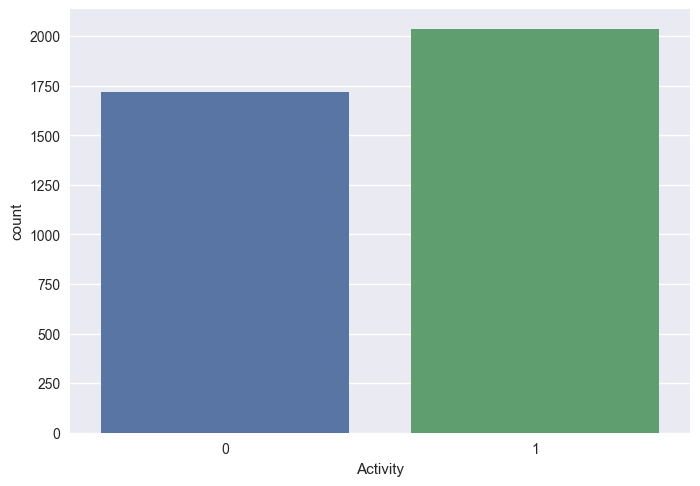

In [5]:
# Смотрим на сбалансированность классов:
display(data['Activity'].value_counts(normalize=True))
sns.countplot(data=data, x='Activity');

In [6]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).
X = data.drop(['Activity'], axis=1)
y = data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)
# проверим соотношения классов
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Test:\n', y_test.value_counts(normalize=True), sep='')

Train:
1    0.542333
0    0.457667
Name: Activity, dtype: float64
Test:
1    0.541944
0    0.458056
Name: Activity, dtype: float64


## *Логистическая регрессия*

In [7]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=50, random_state=42)
#Обучаем модель, минимизируя logloss
%time log_reg.fit(X_train, y_train)

#Выводим значения метрики
y_train_pred = log_reg.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 1.17 s
Wall time: 187 ms
F1_Train: 0.87
F1_Test: 0.79


c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## *Случайный лес*

In [8]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
#Обучаем модель, минимизируя logloss
%time rf.fit(X_train, y_train)

#Выводим значения метрики
y_train_pred = rf.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 1.47 s
Wall time: 1.47 s
F1_Train: 1.00
F1_Test: 0.81


# Оптимизация гиперпараметров модели

## Базовая оптимизация

### **1. GridSearchCV**

#### *Логистическая регрессия*

In [9]:
# подбор гиперпараметров для модели логистической регрессии с помощью поиска по сетке.
# создадим 2 словаря с гиперпараметрами, так как для каждого типа регуляции подходят только определённые алгоритмы оптимизации
param_grid_lr = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'newton-cg', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации

              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]
# вызов класса GridSearchCV и передача модели (LogisticRegression), сетки искомых параметров (param_grid),
# а также число фолдов, которые мы хотим использовать в кросс-валидации, и n_jobs = -1, чтобы использовать все доступные ядра для расчётов
grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5, # количество фолдов в кросс-валидации
    n_jobs = -1   # количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
)
# %time - замеряет время выполнения
%time grid_search_lr.fit(X_train, y_train)

#Выводим значения метрики
y_train_pred = grid_search_lr.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_lr.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

# Наилучшая найденная комбинация гиперпараметров сохраняется в атрибуте best_params_:
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))
# Итоговая модель хранится в параметре best_estimator_, ей можно воспользоваться для получения прогнозов на новых данных:
print("Наилучшая модель:\n{}".format(grid_search_lr.best_estimator_))

CPU times: total: 11.5 s
Wall time: 7min 9s
F1_Train: 0.85
F1_Test: 0.79
Наилучшие значения гиперпараметров: {'C': 0.12, 'penalty': 'l2', 'solver': 'newton-cg'}
Наилучшая модель:
LogisticRegression(C=0.12, max_iter=50, random_state=42, solver='newton-cg')


#### *Случайный лес*

In [10]:
# Проделаем аналогичное для RandomForestClassifier().
param_grid_rf = {'n_estimators': list(range(10, 200, 20)),
              'min_samples_leaf': [3,5,7],
              'max_depth': list(range(10, 40, 5))
              }

grid_search_forest = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs = -1
)
%time grid_search_forest.fit(X_train, y_train)

#Выводим значения метрики
y_train_pred = grid_search_forest.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))
print("Наилучшая модель:\n{}".format(grid_search_forest.best_estimator_))

CPU times: total: 3.94 s
Wall time: 2min 11s
F1_Train: 0.98
F1_Test: 0.83
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 110}
Наилучшая модель:
RandomForestClassifier(max_depth=20, min_samples_leaf=3, n_estimators=110,
                       random_state=42)


### **2. RandomizedSearchCV**

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии и случайного леса с теми же параметрами и сравним результаты

#### *Логистическая регрессия*

In [11]:
# используем те же параметры
random_search_lr = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_grid_lr,
    cv=5,
    n_iter = 50,
    n_jobs = -1
)
%time random_search_lr.fit(X_train, y_train)

# выведем наилучшие значения гиперпараметров и метрики
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))

y_train_pred = random_search_lr.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_lr.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 3.94 s
Wall time: 2min 40s
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.12}
F1_Train: 0.85
F1_Test: 0.79


c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### *Случайный лес*

In [12]:
random_search_forest = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    cv=5,
    n_iter = 50,
    n_jobs = -1
)
%time random_search_forest.fit(X_train, y_train)

# выведем наилучшие значения гиперпараметров и метрики
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

y_train_pred = random_search_forest.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 1.58 s
Wall time: 34.8 s
Наилучшие значения гиперпараметров: {'n_estimators': 70, 'min_samples_leaf': 3, 'max_depth': 35}
F1_Train: 0.97
F1_Test: 0.82


## Продвинутая оптимизация.

### **3. Hyperopt**

In [13]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


#### *Логистическая регрессия*

In [14]:
# зададим пространство поиска гиперпараметров №1
space_1 = {'penalty': hp.choice('penalty', ['l2', 'none']),
        'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'sag']),
        'C': hp.quniform('C', 0.01, 1, 0.01)
      }
# зафиксируем random_state
random_state =42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']),
              'solver': str(params['solver']),
              'C': float(params['C'])
              }

    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=50)

    # обучаем модель
    model.fit(X, y)

    # применим cross validation
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [15]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов
best_1 = fmin(hyperopt_lr, # наша функция
          space=space_1, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

# построим и обучим модель с лучшими гиперпараметрами
model_lr_hyper_1 = linear_model.LogisticRegression(
    penalty=space_eval(space_1, best_1)['penalty'],
        solver=space_eval(space_1, best_1)['solver'],
        C=float(best_1['C']),
        random_state=random_state,
        max_iter=50
)
model_lr_hyper_1.fit(X_train, y_train)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

  2%|▏         | 1/50 [00:00<00:41,  1.19trial/s, best loss: -0.7525843675694686]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  4%|▍         | 2/50 [00:03<01:43,  2.17s/trial, best loss: -0.7761694586133502]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



  8%|▊         | 4/50 [00:09<02:08,  2.80s/trial, best loss: -0.7829592293300918]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 10%|█         | 5/50 [00:10<01:37,  2.17s/trial, best loss: -0.7829592293300918]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 6/50 [00:14<01:53,  2.59s/trial, best loss: -0.7829592293300918]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 16%|█▌        | 8/50 [00:23<02:38,  3.78s/trial, best loss: -0.7829592293300918]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 18%|█▊        | 9/50 [00:24<02:00,  2.93s/trial, best loss: -0.7829592293300918]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|██        | 10/50 [00:27<02:03,  3.08s/trial, best loss: -0.7829592293300918]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 22%|██▏       | 11/50 [00:28<01:33,  2.40s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 13/50 [00:37<02:13,  3.60s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 15/50 [00:47<02:34,  4.40s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 32%|███▏      | 16/50 [00:48<01:53,  3.33s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 36%|███▌      | 18/50 [00:55<01:49,  3.43s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 38%|███▊      | 19/50 [00:58<01:44,  3.37s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 40%|████      | 20/50 [00:59<01:20,  2.68s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 42%|████▏     | 21/50 [01:00<01:03,  2.18s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 44%|████▍     | 22/50 [01:01<00:51,  1.85s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 46%|████▌     | 23/50 [01:02<00:43,  1.61s/trial, best loss: -0.7830111458414548]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 48%|████▊     | 24/50 [01:03<00:37,  1.45s/trial, best loss: -0.783969058294803] 

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 50%|█████     | 25/50 [01:04<00:33,  1.33s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 52%|█████▏    | 26/50 [01:05<00:29,  1.25s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 54%|█████▍    | 27/50 [01:06<00:27,  1.19s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 56%|█████▌    | 28/50 [01:07<00:23,  1.08s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 58%|█████▊    | 29/50 [01:08<00:22,  1.07s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 60%|██████    | 30/50 [01:09<00:21,  1.06s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 62%|██████▏   | 31/50 [01:10<00:18,  1.00trial/s, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 64%|██████▍   | 32/50 [01:11<00:18,  1.02s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 68%|██████▊   | 34/50 [01:16<00:29,  1.85s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 70%|███████   | 35/50 [01:17<00:24,  1.61s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 74%|███████▍  | 37/50 [01:22<00:30,  2.34s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 76%|███████▌  | 38/50 [01:23<00:23,  1.95s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 78%|███████▊  | 39/50 [01:25<00:18,  1.68s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 80%|████████  | 40/50 [01:26<00:14,  1.49s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 42/50 [01:34<00:24,  3.02s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 86%|████████▌ | 43/50 [01:35<00:17,  2.43s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 88%|████████▊ | 44/50 [01:38<00:16,  2.69s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 90%|█████████ | 45/50 [01:40<00:11,  2.20s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



 92%|█████████▏| 46/50 [02:17<00:51, 12.89s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 94%|█████████▍| 47/50 [02:18<00:27,  9.28s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 48/50 [02:22<00:15,  7.51s/trial, best loss: -0.783969058294803]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

100%|██████████| 50/50 [02:29<00:00,  2.98s/trial, best loss: -0.783969058294803]
CPU times: total: 3min 40s
Wall time: 2min 29s


c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.02, max_iter=50, random_state=42)

In [16]:
# зададим пространство поиска гиперпараметров №2
space_2 = {'penalty': hp.choice('penalty', ['l1', 'l2']),
        'solver': hp.choice('solver', ['liblinear', 'saga']),
        'C': hp.quniform('C', 0.01, 1, 0.01)
      }
# зафиксируем random_state
random_state =42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']),
              'solver': str(params['solver']),
              'C': float(params['C'])
              }

    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=50)

    # обучаем модель
    model.fit(X, y)

    # применим cross validation
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [17]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов
best_2 = fmin(hyperopt_lr, # наша функция
          space=space_2, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

# построим и обучим модель с лучшими гиперпараметрами
model_lr_hyper_2 = linear_model.LogisticRegression(
    penalty=space_eval(space_2, best_2)['penalty'],
        solver=space_eval(space_2, best_2)['solver'],
        C=float(best_2['C']),
        random_state=random_state,
        max_iter=50
)
model_lr_hyper_2.fit(X_train, y_train)

  2%|▏         | 1/50 [00:00<00:35,  1.39trial/s, best loss: -0.770982773955998]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  6%|▌         | 3/50 [00:05<01:27,  1.87s/trial, best loss: -0.7778765118027862]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 5/50 [00:10<01:31,  2.03s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 6/50 [00:14<01:52,  2.57s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 18%|█▊        | 9/50 [00:20<01:19,  1.94s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 22%|██▏       | 11/50 [00:25<01:19,  2.03s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 13/50 [00:29<01:14,  2.01s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 14/50 [00:34<01:43,  2.86s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 32%|███▏      | 16/50 [00:40<01:32,  2.71s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▍      | 17/50 [00:43<01:38,  2.97s/trial, best loss: -0.7825317839110804]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 36%|███▌      | 18/50 [00:48<01:49,  3.42s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|████      | 20/50 [00:54<01:31,  3.03s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 42%|████▏     | 21/50 [00:59<01:43,  3.57s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 44%|████▍     | 22/50 [01:03<01:49,  3.91s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 46%|████▌     | 23/50 [01:08<01:53,  4.19s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 48%|████▊     | 24/50 [01:13<01:55,  4.43s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 25/50 [01:18<01:53,  4.54s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 52%|█████▏    | 26/50 [01:23<01:50,  4.59s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 54%|█████▍    | 27/50 [01:27<01:45,  4.60s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 56%|█████▌    | 28/50 [01:32<01:41,  4.59s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 58%|█████▊    | 29/50 [01:37<01:37,  4.66s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 31/50 [01:43<01:13,  3.86s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 64%|██████▍   | 32/50 [01:48<01:14,  4.14s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 66%|██████▌   | 33/50 [01:53<01:12,  4.29s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 68%|██████▊   | 34/50 [01:57<01:10,  4.38s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 35/50 [02:01<01:02,  4.15s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 74%|███████▍  | 37/50 [02:06<00:41,  3.17s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 76%|███████▌  | 38/50 [02:10<00:39,  3.28s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 40/50 [02:15<00:27,  2.73s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 42/50 [02:20<00:19,  2.43s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 86%|████████▌ | 43/50 [02:23<00:19,  2.80s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 45/50 [02:29<00:13,  2.66s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 46/50 [02:33<00:11,  2.96s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 48/50 [02:38<00:05,  2.55s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 98%|█████████▊| 49/50 [02:41<00:02,  2.86s/trial, best loss: -0.7838598962869202]

c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 50/50 [02:46<00:00,  3.33s/trial, best loss: -0.7838598962869202]
CPU times: total: 1min 20s
Wall time: 2min 48s


c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.11, max_iter=50, penalty='l1', random_state=42,
                   solver='saga')

In [18]:
# выведем наилучшие значения гиперпараметров и метрики
print(f'Наилучшие значения гиперпараметров_1 {space_eval(space_1, best_1)}')

y_train_pred = model_lr_hyper_1.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_lr_hyper_1.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print(f'Наилучшие значения гиперпараметров_2 {space_eval(space_2, best_2)}')

y_train_pred = model_lr_hyper_2.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_lr_hyper_2.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров_1 {'C': 0.02, 'penalty': 'l2', 'solver': 'lbfgs'}
F1_Train: 0.83
F1_Test: 0.79
Наилучшие значения гиперпараметров_2 {'C': 0.11, 'penalty': 'l1', 'solver': 'saga'}
F1_Train: 0.81
F1_Test: 0.78


#### *Случайный лес*

In [19]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 10, 200, 20),
       'max_depth' : hp.quniform('max_depth', 10, 40, 5),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 2)
      }
# зафиксируем random_state
random_state =42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)

    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [20]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов
best = fmin(hyperopt_rf, # наша функция
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

# построим и обучим модель с лучшими гиперпараметрами
model_forest_hyper = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model_forest_hyper.fit(X_train, y_train)

100%|██████████| 50/50 [02:22<00:00,  2.84s/trial, best loss: -0.8097955161337937]
CPU times: total: 1min 6s
Wall time: 2min 24s


RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [21]:
# выведем наилучшие значения гиперпараметров и метрики
print("Наилучшие значения гиперпараметров {}".format(best))

y_train_pred = model_forest_hyper.predict(X_train)
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_forest_hyper.predict(X_test)
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'max_depth': 15.0, 'min_samples_leaf': 4.0, 'n_estimators': 200.0}
F1_Train: 0.95
F1_Test: 0.83


### **4. Optuna**

In [22]:
import optuna
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.3.0


#### *Логистическая регрессия*

In [23]:
# Настроим оптимизацию гиперпараметров для логистической регрессии с параметрами №1
def optuna_lr_1(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag'])
  C = trial.suggest_float("C", 0.01, 1, step=0.01)

  # Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state,
                                          max_iter=50)
  # обучаем модель
  model.fit(X_train, y_train)
  # применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [24]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_1 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_1.optimize(optuna_lr_1, n_trials=50)

# строим и обучаем модель
model_opt_lr_1 = linear_model.LogisticRegression(**study_1.best_params,random_state=random_state, max_iter=50)
model_opt_lr_1.fit(X_train, y_train)

[I 2023-09-03 21:36:08,623] A new study created in memory with name: LogisticRegression
c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-03 21:36:12,127] Trial 0 finished with value: 0.7683043585976091 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.65}. Best is trial 0 with value: 0.7683043585976091.
c:\Users\Юзер\AppData\Local\Programs\Python\Pyth

CPU times: total: 6min 13s
Wall time: 4min 24s


c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.03, max_iter=50, random_state=42, solver='sag')

In [25]:
# Настроим оптимизацию гиперпараметров для логистической регрессии с параметрами №2
def optuna_lr_2(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float("C", 0.01, 1, step=0.01)

  # Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state,
                                          max_iter=50)
  # обучаем модель
  model.fit(X_train, y_train)
  # применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [26]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_2 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_2.optimize(optuna_lr_2, n_trials=50)

# строим и обучаем модель
model_opt_lr_2 = linear_model.LogisticRegression(**study_2.best_params,random_state=random_state, max_iter=50)
model_opt_lr_2.fit(X_train, y_train)

[I 2023-09-03 21:40:33,067] A new study created in memory with name: LogisticRegression
[I 2023-09-03 21:40:33,965] Trial 0 finished with value: 0.7700265703482703 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.91}. Best is trial 0 with value: 0.7700265703482703.
c:\Users\Юзер\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-03 21:40:38,757] Trial 1 finished with value: 0.7803872830087195 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.41000000000000003}. Best is trial 1 with value: 0.7803872830087195.
[I 2023-09-03 21:40:39,587] Trial 2 finished with value: 0.7782275253034513 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.47000000000000003}. Best is trial 1 with value: 0.7803872830087195.
[I 2023-09-03 21:40:40,463] Trial 3 finished with value: 0.7772949879061344 and parameters: {'penalty

CPU times: total: 27 s
Wall time: 1min 8s


LogisticRegression(C=0.19, max_iter=50, penalty='l1', random_state=42,
                   solver='liblinear')

In [27]:
# выведем наилучшие значения гиперпараметров и метрики
print("Наилучшие значения гиперпараметров_1 {}".format(study_1.best_params))

print("f1_score на обучающей выборке: {:.2f}".format(study_1.best_value))
y_test_pred = model_opt_lr_1.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров_2 {}".format(study_2.best_params))

print("f1_score на обучающей выборке: {:.2f}".format(study_2.best_value))
y_test_pred = model_opt_lr_2.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров_1 {'penalty': 'l2', 'solver': 'sag', 'C': 0.03}
f1_score на обучающей выборке: 0.78
f1_score на тестовой выборке: 0.80
Наилучшие значения гиперпараметров_2 {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.19}
f1_score на обучающей выборке: 0.78
f1_score на тестовой выборке: 0.79


#### *Случайный лес*

In [28]:
# Настроим оптимизацию гиперпараметров для алгоритма случайного леса.
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 20)
  max_depth = trial.suggest_int('max_depth', 10, 40, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 2)

  # Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state
                                          )
  # обучаем модель
  model.fit(X_train, y_train)
  # применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [29]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# строим и обучаем модель
model_opt_rf = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model_opt_rf.fit(X_train, y_train)

[I 2023-09-03 21:42:43,875] A new study created in memory with name: RandomForestClassifier
[I 2023-09-03 21:42:47,565] Trial 0 finished with value: 0.7906101910028582 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7906101910028582.
[I 2023-09-03 21:42:50,658] Trial 1 finished with value: 0.8086765985526417 and parameters: {'n_estimators': 120, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8086765985526417.
[I 2023-09-03 21:42:54,018] Trial 2 finished with value: 0.7906101910028582 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8086765985526417.
[I 2023-09-03 21:42:56,645] Trial 3 finished with value: 0.8006739006971187 and parameters: {'n_estimators': 120, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8086765985526417.
[I 2023-09-03 21:43:00,752] Trial 4 finished with value: 0.800298280095139 and parameters: {'n_e

CPU times: total: 1min 11s
Wall time: 2min 36s


RandomForestClassifier(max_depth=20, min_samples_leaf=3, n_estimators=120,
                       random_state=42)

In [30]:
# выведем наилучшие значения гиперпараметров и метрики
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# выведим значения метрики
print("f1_score на обучающей выборке: {:.2f}".format(study.best_value))
y_test_pred = model_opt_rf.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 120, 'max_depth': 20, 'min_samples_leaf': 3}
f1_score на обучающей выборке: 0.81
f1_score на тестовой выборке: 0.83


Рассмотрим различные визуализации для модели случайного леса, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [31]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [32]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [33]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметров max_depth и min_sampeles_leaf

# **Выводы**
По итогу обучения двух моделей: логистическая регрессия и случайный лес, и подбора гиперпараметров с помощью базовых и продвинутых методов оптимизации, получились следующие результаты:


**Логистическая регрессия**

- параметры по умолчанию:
Wall time: 187 ms,
F1_Test: 0.79

- GridSearchCV:
Наилучшие значения гиперпараметров: {'C': 0.12, 'penalty': 'l2', 'solver': 'newton-cg'},
Wall time: 7min 9s,
F1_Test: 0.79

- RandomizedSearchCV:
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.12},
Wall time: 2min 40s,
F1_Test: 0.79

- Hyperopt:
Наилучшие значения гиперпараметров_1 {'C': 0.02, 'penalty': 'l2', 'solver': 'lbfgs'},
Wall time: 5min 17s,
F1_Test: 0.79

- Optuna:
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.03},
Wall time: 6min 53s,
F1_Test: 0.80

**Случайный лес**

- параметры по умолчанию:
Wall time: 1.47 s,
F1_Test: 0.81

- GridSearchCV:
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 110},
Wall time: 2min 11s,
F1_Test: 0.83

- RandomizedSearchCV:
Наилучшие значения гиперпараметров: {'n_estimators': 70, 'min_samples_leaf': 3, 'max_depth': 35},
Wall time: 34.8 s,
F1_Test: 0.82

- Hyperopt:
Наилучшие значения гиперпараметров {'max_depth': 15.0, 'min_samples_leaf': 4.0, 'n_estimators': 200.0},
Wall time: 2min 24s,
F1_Test: 0.83

- Optuna:
Наилучшие значения гиперпараметров {'n_estimators': 120, 'max_depth': 20, 'min_samples_leaf': 3},
Wall time: 2min 36s,
F1_Test: 0.83

У модели случайный лес в результате подбора гиперпараметров удалось улучшить метрику с помощью всех методов оптимизации, у RandomizedSearchCV чуть ниже, но при повторном прогоне метрики сравниваются. По времени лучше всего справился RandomizedSearchCV - за 34,8 секунд, дольше всех (незначительно) - Optuna, за 2мин 36сек.

У модели логистическая регрессия только метод оптимизации Optuna улучшил метрику на 1%, но при повторном прогоне метрики сравниваются. По времени лучше всех справился RandomizedSearchCV (как и у случайного леса) - 2 мин 40 сек, дольше всех - GridSearchCV, 7 мин 9сек.
Из минусов - у продвинутых методов оптимизации нельзя задать пространство поиска гиперпараметров в виде нескольких словарей для логистической регрессии, в результате чего время подбора гиперпараметров увеличивается.

Что интересно, разные методы оптимизации выдают разные гиперпараметры для одной модели.

Считаю лучшим методом для подбора гиперпараметров - RandomizedSearchCV, т.к. при разных прогонах расчета метрики сравниваются, а времени данный метод расходует меньше всего, как для расчета, так и для написания кода.